In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sys
import psutil
import time

# Function to measure memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # in MB

# Function to measure model size
def get_model_size(model):
    model.save("temp_model.h5")  # Save model to disk
    size = os.path.getsize("temp_model.h5") / (1024 * 1024)  # Convert to MB
    os.remove("temp_model.h5")  # Remove temporary file
    return size

In [2]:
# Step 1: Load Pretrained CNN Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Feature extractor from last convolutional layer (Captures edges, textures, shapes, and patterns)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# GAP feature extractor
# Summarizes features by taking the average of each pattern.
# Removes unnecessary details but keeps important ones.
gap_layer = GlobalAveragePooling2D()(base_model.output)
gap_model = Model(inputs=base_model.input, outputs=gap_layer)

# Fully connected layer feature extractor
# This method removes all spatial details and only keeps high-level informatio
fc_model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [3]:
# Step 2: Load and Preprocess Images
dataset_path = "new_dataset"  # Change this to your dataset path
image_size = (64, 64)
X, y = [], []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = Image.open(image_path).convert("RGB").resize(image_size)
                image_array = np.array(image)
                X.append(image_array)
                y.append(class_folder)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

# Convert to NumPy arrays
X = np.array(X) / 255.0  # Normalize
y = np.array(y)



c:\Users\Owenn\Desktop\Github\P5-7-INF2008-Machine-Learning-ML\.venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Step 3: Extract Features
print("Extracting features...")

start_time = time.time()
X_train_conv = feature_extractor.predict(X_train)
X_val_conv = feature_extractor.predict(X_val)
X_test_conv = feature_extractor.predict(X_test)
conv_time = time.time() - start_time
conv_memory = get_memory_usage()

start_time = time.time()
X_train_gap = gap_model.predict(X_train)
X_val_gap = gap_model.predict(X_val)
X_test_gap = gap_model.predict(X_test)
gap_time = time.time() - start_time
gap_memory = get_memory_usage()

start_time = time.time()
X_train_fc = fc_model.predict(X_train)
X_val_fc = fc_model.predict(X_val)
X_test_fc = fc_model.predict(X_test)
fc_time = time.time() - start_time
fc_memory = get_memory_usage()

print(f"Feature Extraction Time (Conv): {conv_time:.2f} sec, Memory Usage: {conv_memory:.2f} MB")
print(f"Feature Extraction Time (GAP): {gap_time:.2f} sec, Memory Usage: {gap_memory:.2f} MB")
print(f"Feature Extraction Time (FC): {fc_time:.2f} sec, Memory Usage: {fc_memory:.2f} MB")

# Flatten all feature representations
X_train_conv = X_train_conv.reshape(X_train_conv.shape[0], -1)
X_val_conv = X_val_conv.reshape(X_val_conv.shape[0], -1)
X_test_conv = X_test_conv.reshape(X_test_conv.shape[0], -1)

X_train_gap = X_train_gap.reshape(X_train_gap.shape[0], -1)
X_val_gap = X_val_gap.reshape(X_val_gap.shape[0], -1)
X_test_gap = X_test_gap.reshape(X_test_gap.shape[0], -1)

X_train_fc = X_train_fc.reshape(X_train_fc.shape[0], -1)
X_val_fc = X_val_fc.reshape(X_val_fc.shape[0], -1)
X_test_fc = X_test_fc.reshape(X_test_fc.shape[0], -1)

Extracting features...
301/301 ━━━━━━━━━━━━━━━━━━━━ 55s 180ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 52s 173ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step
Feature Extraction Time (Conv): 88.92 sec, Memory Usage: 2982.46 MB
Feature Extraction Time (GAP): 76.55 sec, Memory Usage: 3087.00 MB
Feature Extraction Time (FC): 90.34 sec, Memory Usage: 3196.26 MB


In [5]:
# Step 4: Train and Evaluate Random Forest on Each Feature Set
def train_evaluate_rf(X_train, X_val, y_train, y_val, method_name, return_model=False):
    """ Train and evaluate Random Forest classifier, return model if required """
    print(f"\nTraining Random Forest on {method_name} Features...")
    
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)

    print(f"\nEvaluating RF on {method_name} Features (Validation Set)...")
    y_val_pred = rf.predict(X_val)

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_val_pred))

    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy ({method_name}): {val_accuracy * 100:.2f}%")

    if return_model:
        return rf, val_accuracy  
    else:
        return val_accuracy

# Train and evaluate RF on each feature extraction method
accuracy_conv = train_evaluate_rf(X_train_conv, X_val_conv, y_train, y_val, "Last Convolutional Layer")
rf_gap, accuracy_gap = train_evaluate_rf(X_train_gap, X_val_gap, y_train, y_val, "Global Average Pooling", return_model=True)
accuracy_fc = train_evaluate_rf(X_train_fc, X_val_fc, y_train, y_val, "Fully Connected Layer")

# Step 5: Compare Results
print("\nFinal Comparison of Feature Extraction Methods (Random Forest - Validation Set):")
print(f"Last Convolutional Layer Accuracy: {accuracy_conv * 100:.2f}%")
print(f"Global Average Pooling Accuracy: {accuracy_gap * 100:.2f}%")
print(f"Fully Connected Layer Accuracy: {accuracy_fc * 100:.2f}%")


Training Random Forest on Last Convolutional Layer Features...

Evaluating RF on Last Convolutional Layer Features (Validation Set)...

Confusion Matrix:
[[39  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0
   0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  1  0  0  0]
 [ 0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  2  0
   0  0  2  0  0  0]
 [ 0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1
   0  0  2  0  0  0]
 [ 1  0  0  0 28  0  0  0  0  0  0  0  0  0  1  0  0  2  1  0  0  0  0  0
   0  0  2  1  0  0]
 [ 0  0  0  0  0 37  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0  0]
 [ 0  0  0  0  1  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  2  0  0  0]
 [ 0  0  0  1  0  2  0  1 46  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0
   0  0  2 

In [6]:
# Step 7: Hyperparameter Tuning with Grid Search
print("\nTuning Random Forest Hyperparameters...")
param_grid_rf = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 40, 50],
    "min_samples_split": [2, 3],
    "min_samples_leaf": [1, 2]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring="accuracy")
grid_search_rf.fit(X_train_gap, y_train)

best_params_rf = grid_search_rf.best_params_
print(f"Best RF Parameters: {best_params_rf}")
print(f"Best Cross-Validation Accuracy (RF): {grid_search_rf.best_score_ * 100:.2f}%")


Tuning Random Forest Hyperparameters...
Best RF Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best Cross-Validation Accuracy (RF): 89.43%


In [7]:
# Step 8: Train Tuned RF with Best Parameters
rf_tuned = grid_search_rf.best_estimator_
print("\nEvaluating Tuned RF on Test Set...")
y_test_pred = rf_tuned.predict(X_test_gap)


Evaluating Tuned RF on Test Set...


In [8]:
# Step 9: Evaluate Tuned RF
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Measure final model size and memory usage
conv_model_size = get_model_size(feature_extractor)
gap_model_size = get_model_size(gap_model)
fc_model_size = get_model_size(fc_model)
final_memory_usage = get_memory_usage()

print(f"Last Convolutional Layer Model Size: {conv_model_size:.2f} MB")
print(f"Global Average Pooling Model Size: {gap_model_size:.2f} MB")
print(f"Fully Connected Layer Model Size: {fc_model_size:.2f} MB")
print(f"Final Memory Usage: {final_memory_usage:.2f} MB")


Confusion Matrix (Test):
[[ 73   0   0   0   1   0   0   0   0   0   0   0   0   0   1   0   0   1
    0   0   1   0   1   0   0   0   0   2   0   0]
 [  0  85   0   0   0   1   0   2   1   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   0  87   0   0   0   0   0   0   1   0   0   0   0   0   0   0   3
    0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   0  88   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  75   0   0   0   0   1   0   0   1   0   1   1   0   2
    0   1   0   0   0   0   0   0   0   2   1   0]
 [  0   1   0   0   1  80   0   3   1   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  78   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   1   0]
 [  0   0   0   0   0   1   0  82   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0

Last Convolutional Layer Model Size: 56.20 MB
Global Average Pooling Model Size: 56.20 MB
Fully Connected Layer Model Size: 56.20 MB
Final Memory Usage: 806.50 MB



Number of Misclassified Images: 190


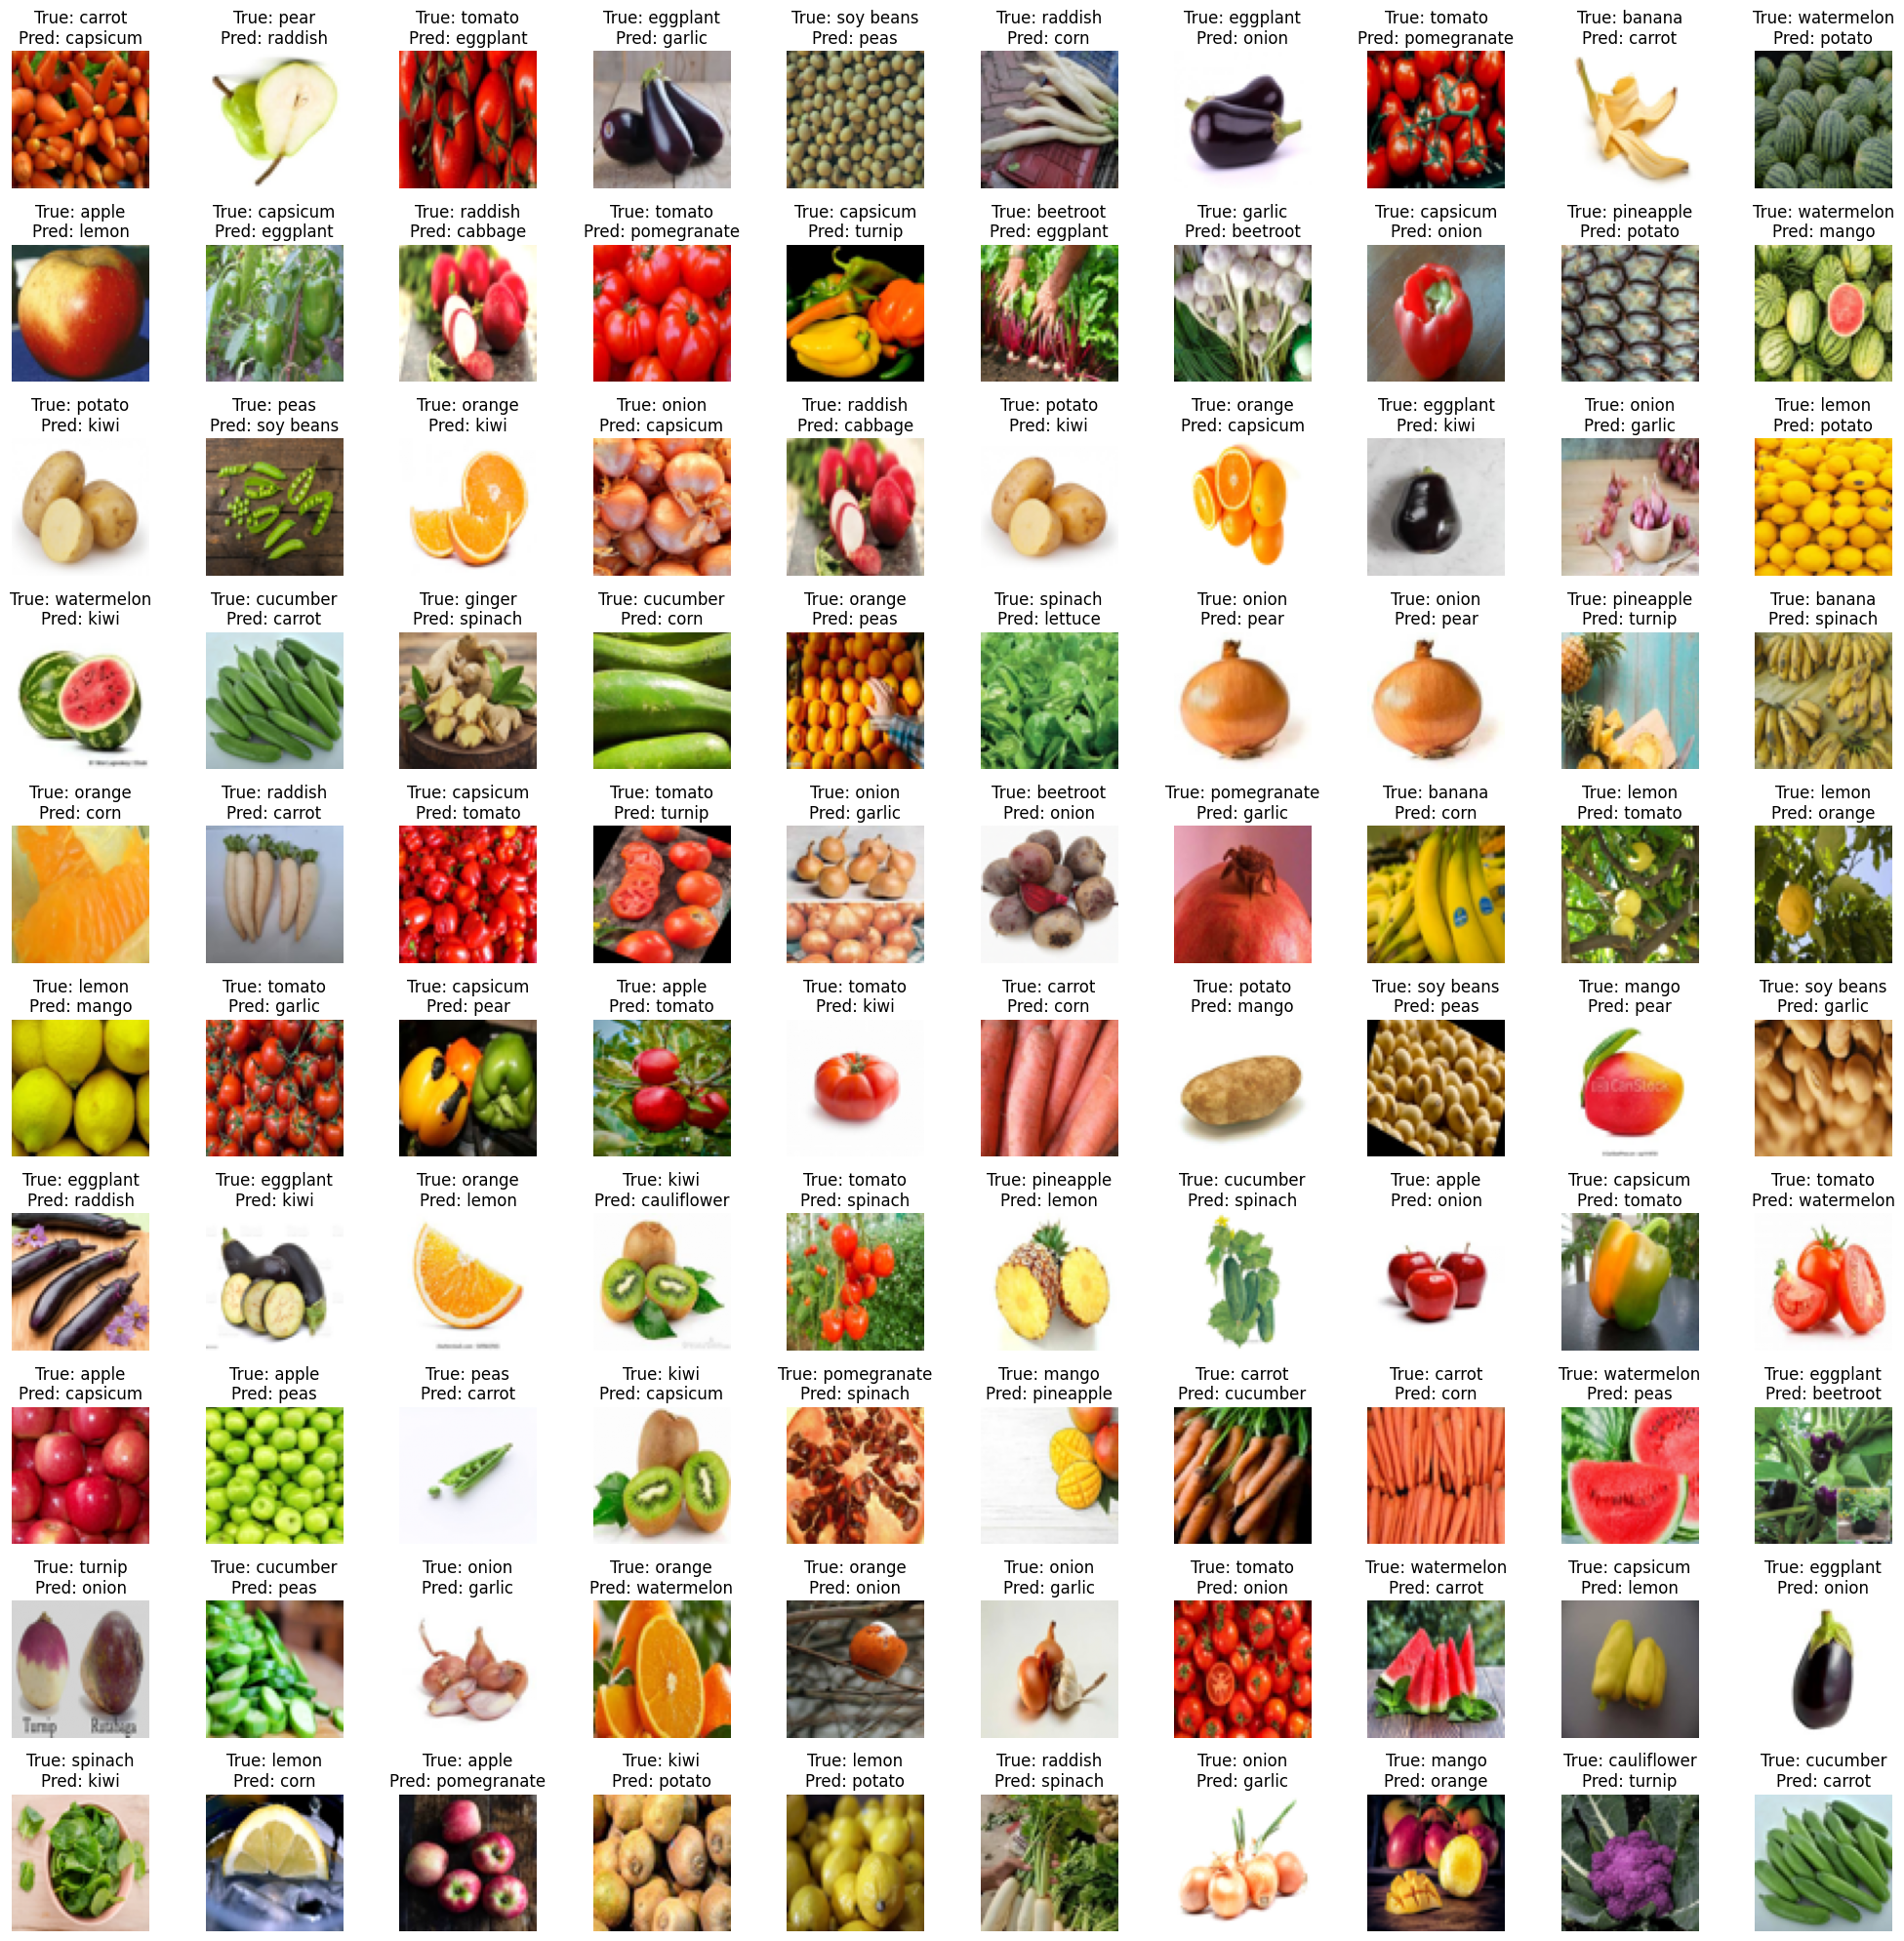

In [9]:
# Step 9: Investigate misclassified images
misclassified_indices = np.where(y_test != y_test_pred)[0]
print(f"\nNumber of Misclassified Images: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    axes = axes.ravel()
    for i in range(min(100, len(misclassified_indices))):
        idx = misclassified_indices[i]
        axes[i].imshow(X_test[idx])
        axes[i].set_title(f"True: {y_test[idx]}\nPred: {y_test_pred[idx]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()